# Ford GoBike Bike Sharing Data Explanatory Analysis

## by Kai-Sheng Wang

## Investigation Overview ##

In this invetigation, I'm interested in finding out how the bike sharing service is used, especially if any pattern exists, and whether a user's gender, age and user type determine how he or she uses the service.

## Dataset Overview ##

The original datasets contain the information about 2,290,554 bike rides with 16 columns. There are 2,161,106 rides left after initial data cleaning. 2 time-relevant variables ('start_time', 'end_time') are converted to datetime data type. The latitude and longitude coordinates of both start and end locations are provided. One numeric variable ('member_birth_year') and two categorical variables ('user_type', 'member_gender') about the users are also available.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
import warnings

%matplotlib inline

- Import packages and set plot to be embedded inline

In [2]:
df_201805 = pd.read_csv('trip_data_files/201805-fordgobike-tripdata.csv')
df_201806 = pd.read_csv('trip_data_files/201806-fordgobike-tripdata.csv')
df_201807 = pd.read_csv('trip_data_files/201807-fordgobike-tripdata.csv')
df_201808 = pd.read_csv('trip_data_files/201808-fordgobike-tripdata.csv')
df_201809 = pd.read_csv('trip_data_files/201809-fordgobike-tripdata.csv')
df_201810 = pd.read_csv('trip_data_files/201810-fordgobike-tripdata.csv')
df_201811 = pd.read_csv('trip_data_files/201811-fordgobike-tripdata.csv')
df_201812 = pd.read_csv('trip_data_files/201812-fordgobike-tripdata.csv')
df_201901 = pd.read_csv('trip_data_files/201901-fordgobike-tripdata.csv')
df_201902 = pd.read_csv('trip_data_files/201902-fordgobike-tripdata.csv')
df_201903 = pd.read_csv('trip_data_files/201903-fordgobike-tripdata.csv')
df_201904 = pd.read_csv('trip_data_files/201904-fordgobike-tripdata.csv')

frames = [df_201805, df_201806, df_201807, df_201808, 
          df_201809, df_201810, df_201811, df_201812, 
          df_201901, df_201902, df_201903, df_201904]

df = pd.concat(frames, ignore_index=True)

- Load the files and merge the datasets into a dataframe

In [3]:
df_clean = df.copy()

- Create a copy for data cleaning

In [4]:
df_clean = df_clean[pd.notnull(df_clean['start_station_id'])]
df_clean = df_clean[pd.notnull(df_clean['member_birth_year'])]
df_clean = df_clean[pd.notnull(df_clean['member_gender'])]

- Entries with null values in three columns removed

In [5]:
df_clean['start_time'] = pd.to_datetime(df['start_time'])
df_clean['end_time'] = pd.to_datetime(df['end_time'])

- Convert two time-relevant variables 'start_time' and 'end_time' to datetime data type

In [6]:
df_clean['member_age'] = 2019 - df_clean['member_birth_year']
df_clean['member_age_group'] = df_clean['member_age'].apply(lambda x: '18-19' if 18<=x<20
                                                            else '20-29' if 20<=x<30
                                                            else '30-39' if 30<=x<40
                                                            else '40-49' if 40<=x<50
                                                            else '50-59' if 50<=x<60
                                                            else '60 or over')
df_clean['start_time_year_month'] = df_clean['start_time'].map(lambda x: x.strftime('%Y-%m'))
df_clean['end_time_year_month'] = df_clean['end_time'].map(lambda x: x.strftime('%Y-%m'))
df_clean['duration_min'] = df_clean['duration_sec']/60

def coordinates_distance(start, end):
    lat1, lon1 = start
    lat2, lon2 = end
    radius = 6371
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat/2)*math.sin(dlat/2)+math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)*math.sin(dlon/2))
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    
    return d

df_clean['distance'] = df_clean.apply(lambda x: coordinates_distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
df_clean['start_time_weekday'] = df_clean['start_time'].dt.weekday_name
df_clean['end_time_weekday'] = df_clean['end_time'].dt.weekday_name
df_clean['start_time_hour'] = df_clean['start_time'].dt.hour
df_clean['end_time_hour'] = df_clean['end_time'].dt.hour

- A new variable 'member_age' (user's age) created
- A new variable 'member_age_group' (users divided into six age groups) created
- Two new variables 'start_time_year_month', 'end_time_year_month' (time variables in 'yyyy-mm' format) created
- A new variable 'duration_min' (duration of ride in minutes) created
- A new variable 'distance' (distance between start and end coordinates in kilometer) created
- Two new variables 'start_time_weekday', 'end_time_weekday' (time variables in day of week format) created
- Two new variables 'start_time_hour', 'end_time_hour' (time variables in hour of day format) created

In [7]:
df_clean = df_clean.query('member_age <= 100')
df_clean = df_clean[df_clean['distance'] <= 50]

- Maximum value of age is 141, which is very unlikely. Entries with users more than 100 years of age removed
- As deviant travel distance is not of the interest of this analysis, 21 entries with travel distance more than 50 kilometer are removed

In [8]:
base_color = sb.color_palette()[0]
alt_color = sb.color_palette()[1]

## Distribution of Ride Time

- Monthly ride count ranges between 150,000 and 200,000 from May 2018 to February 2019
- There is a significant drop of count in November and December, 2018, which may be due to the weather
- There is a big jump of ride count in March 2019. The count drops slightly in the following month, but still fairly higher than the counts in 2018
- The demand for the service is significantly higher during the week (Monday to Friday) than weekends
- The peak hours of the service are from 8 to 9 a.m. and 4 to 6 p.m.

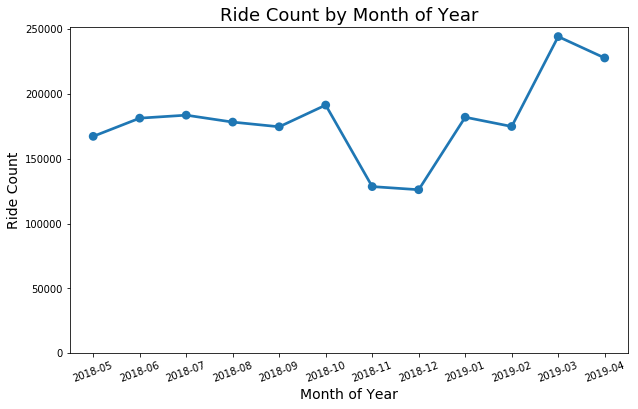

In [9]:
df_count_month = df_clean.groupby(['start_time_year_month']).size().reset_index()
plt.figure(figsize=(10, 6))
ax = sb.pointplot(data=df_count_month, x='start_time_year_month', y=0)
plt.title('Ride Count by Month of Year', fontsize=18)
plt.xlabel('Month of Year', fontsize=14)
plt.ylabel('Ride Count', fontsize=14)
plt.ylim(0,)
plt.xticks(rotation=20);

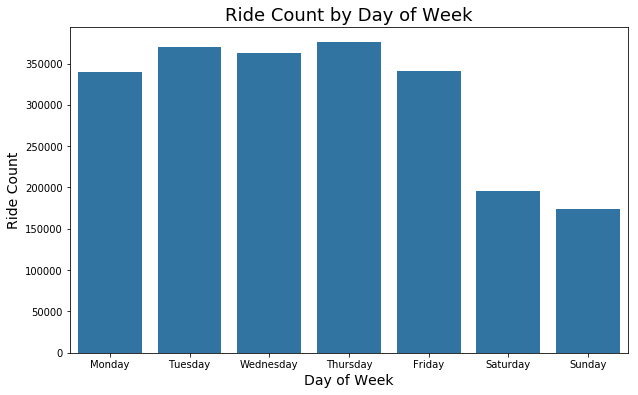

In [10]:
weekday_index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
sb.countplot(data=df_clean, x='start_time_weekday', color=base_color, order=weekday_index)
plt.title("Ride Count by Day of Week", fontsize=18)
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Ride Count", fontsize=14);

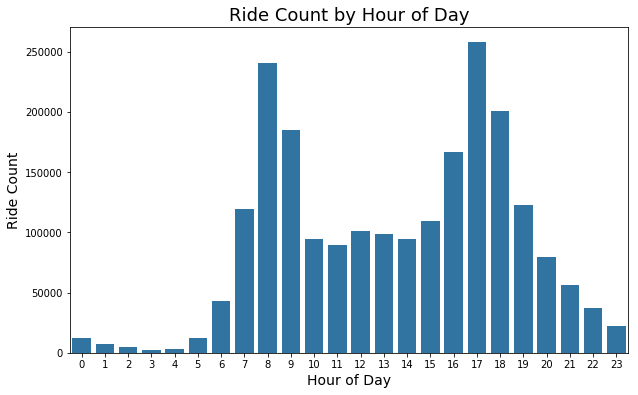

In [11]:
plt.figure(figsize=(10, 6))
sb.countplot(data=df_clean, x='start_time_hour', color=base_color)
plt.title("Ride Count by Hour of Day", fontsize=18)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Ride Count", fontsize=14);

## Distance vs. Duration

- Most rides are within 4 kilometer in distance and 20 minutes in duration. There is a linear correlation between distance and duration per ride within this range
- The most frequent rides are about 0.5 to 1 kilometer in distance and 3 to 5 minutes in duration
- Duration per ride is relatively shorter between November 2018 and February 2019. However, the distance per ride during this period of time is not significantly shorter
- Distance per ride increases steadily over time
- Duration per ride is longer on weekends, but the distance per ride becomes shorter

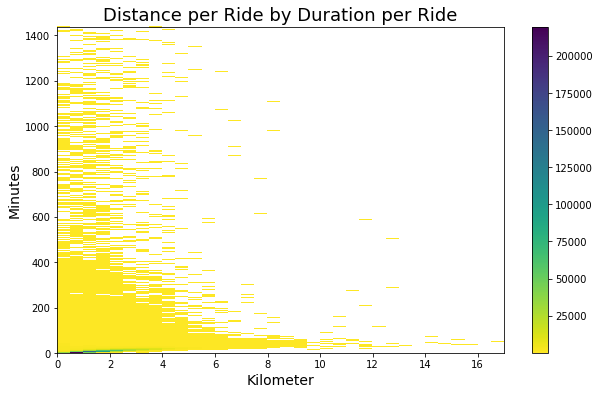

In [12]:
plt.figure(figsize=(10, 6))
bins_x = np.arange(0, df_clean['distance'].max()+0.5, 0.5)
bins_y = np.arange(1, df_clean['duration_min'].max()+2, 2)
plt.hist2d(data=df_clean, x='distance', y='duration_min', bins=[bins_x, bins_y], cmap='viridis_r', cmin=0.5)
plt.colorbar()
plt.title('Distance per Ride by Duration per Ride', fontsize=18)
plt.xlabel('Kilometer', fontsize=14)
plt.ylabel('Minutes', fontsize=14);

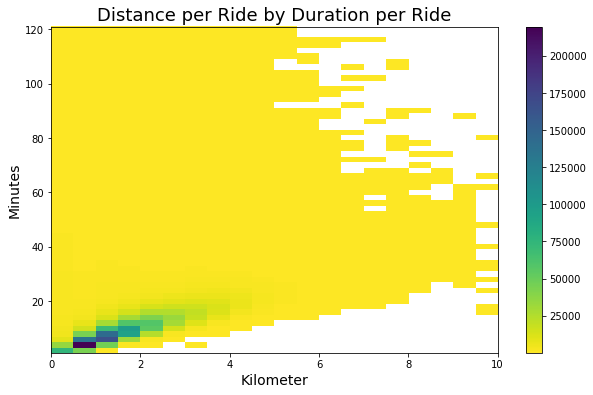

In [13]:
df_min_dis = df_clean[(df_clean['distance'] <= 10) & (df_clean['duration_min'] <= 120)]
plt.figure(figsize=(10, 6))
bins_x = np.arange(0, df_min_dis['distance'].max()+0.5, 0.5)
bins_y = np.arange(1, df_min_dis['duration_min'].max()+2, 2)
plt.hist2d(data=df_min_dis, x='distance', y='duration_min', bins=[bins_x, bins_y], cmap='viridis_r', cmin=0.5)
plt.colorbar()
plt.title('Distance per Ride by Duration per Ride', fontsize=18)
plt.xlabel('Kilometer', fontsize=14)
plt.ylabel('Minutes', fontsize=14);

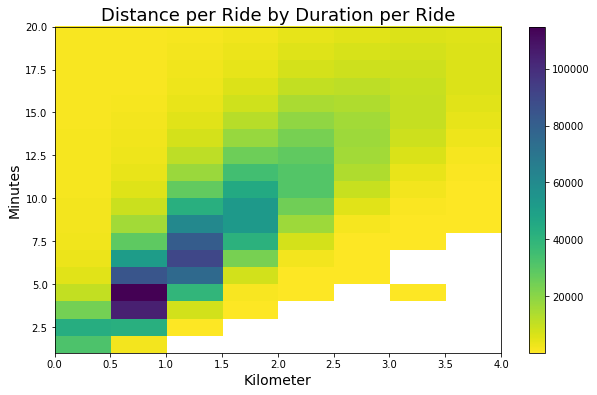

In [14]:
df_min_dis_2 = df_clean[(df_clean['distance'] <= 4) & (df_clean['duration_min'] <= 20)]
plt.figure(figsize=(10, 6))
bins_x = np.arange(0, df_min_dis_2['distance'].max()+0.5, 0.5)
bins_y = np.arange(1, df_min_dis_2['duration_min'].max()+1, 1)
plt.hist2d(data=df_min_dis_2, x='distance', y='duration_min', bins=[bins_x, bins_y], cmap='viridis_r', cmin=0.5)
plt.colorbar()
plt.title('Distance per Ride by Duration per Ride', fontsize=18)
plt.xlabel('Kilometer', fontsize=14)
plt.ylabel('Minutes', fontsize=14);

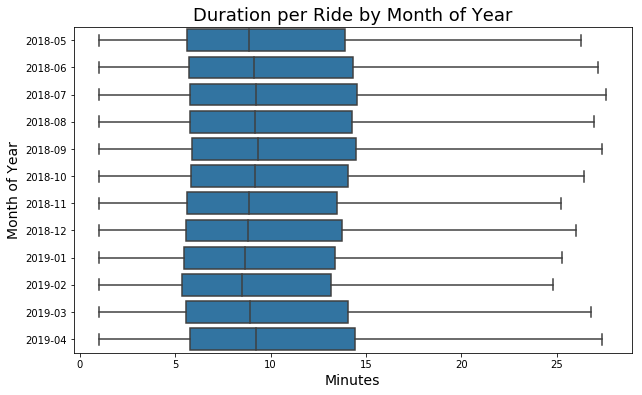

In [15]:
plt.figure(figsize=(10, 6))
sb.boxplot(data=df_clean, x='duration_min', y='start_time_year_month', color=base_color, showfliers=False)
plt.title('Duration per Ride by Month of Year', fontsize=18)
plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Month of Year', fontsize=14);

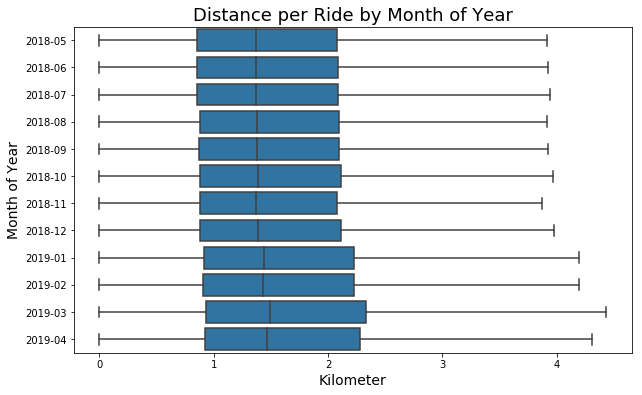

In [16]:
plt.figure(figsize=(10, 6))
sb.boxplot(data=df_clean, x='distance', y='start_time_year_month', color=base_color, showfliers=False)
plt.title('Distance per Ride by Month of Year', fontsize=18)
plt.xlabel('Kilometer', fontsize=14)
plt.ylabel('Month of Year', fontsize=14);

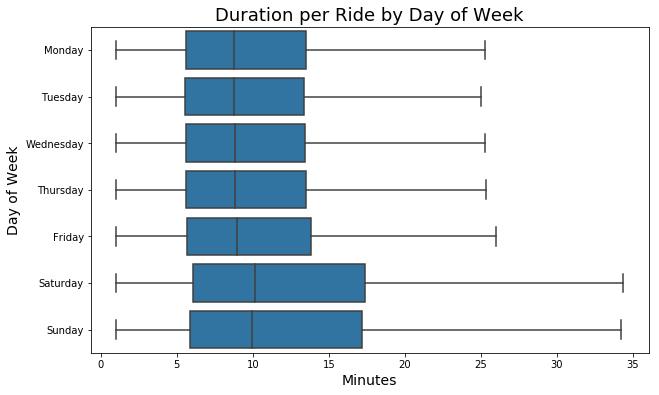

In [17]:
plt.figure(figsize=(10, 6))
sb.boxplot(data=df_clean, x='duration_min', y='start_time_weekday', color=base_color, order=weekday_index, showfliers=False)
plt.title('Duration per Ride by Day of Week', fontsize=18)
plt.xlabel('Minutes', fontsize=14)
plt.ylabel('Day of Week', fontsize=14);

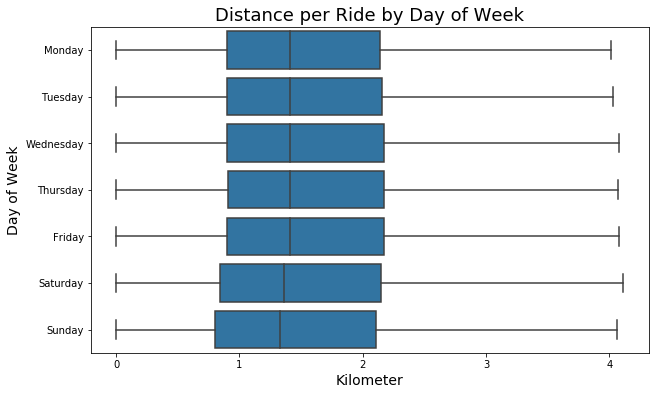

In [18]:
plt.figure(figsize=(10, 6))
sb.boxplot(data=df_clean, x='distance', y='start_time_weekday', color=base_color, order=weekday_index, showfliers=False)
plt.title('Distance per Ride by Day of Week', fontsize=18)
plt.xlabel('Kilometer', fontsize=14)
plt.ylabel('Day of Week', fontsize=14);

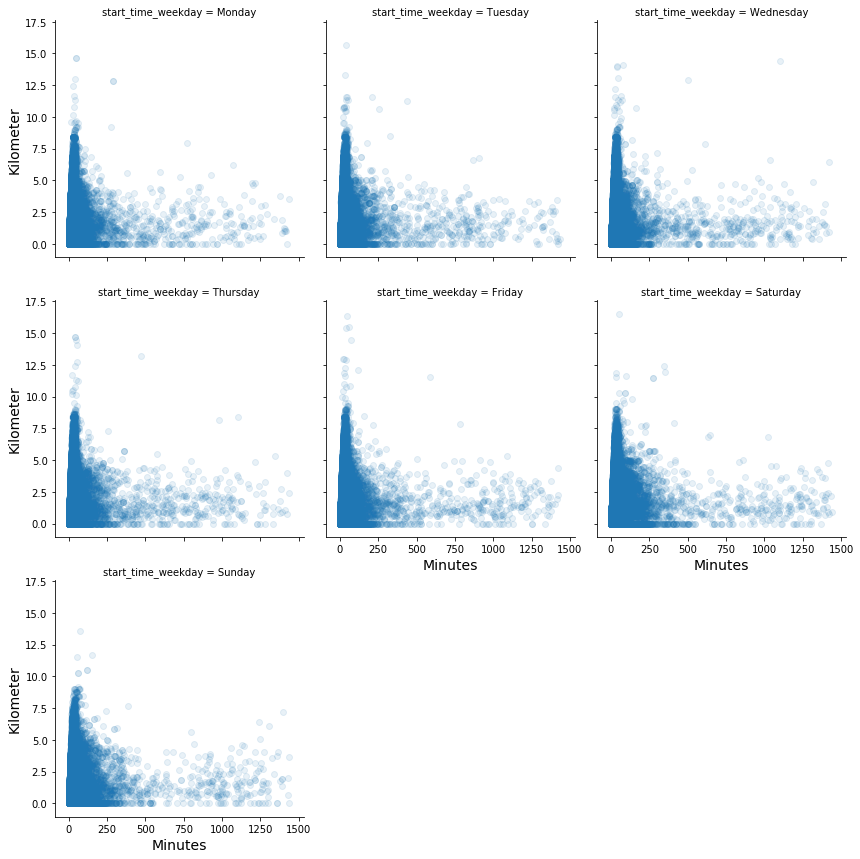

In [19]:
g = sb.FacetGrid(data=df_clean, col='start_time_weekday', col_order=weekday_index, col_wrap=3, size=4)
g.map(plt.scatter, 'duration_min', 'distance', alpha=0.1)
g.set_xlabels('Minutes', fontsize=14)
g.set_ylabels('Kilometer', fontsize=14);

## Gender

- Rides by male users are more than twice as much than female users
- Female users generally spend more time per ride than male users

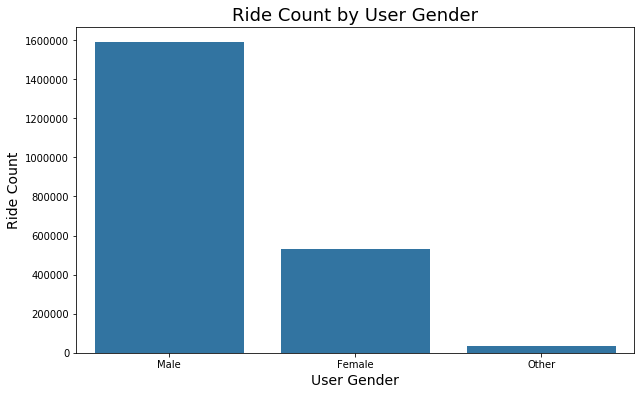

In [20]:
plt.figure(figsize=(10, 6))
sb.countplot(data=df_clean, x='member_gender', color=base_color)
plt.title("Ride Count by User Gender", fontsize=18)
plt.xlabel("User Gender", fontsize=14)
plt.ylabel("Ride Count", fontsize=14);

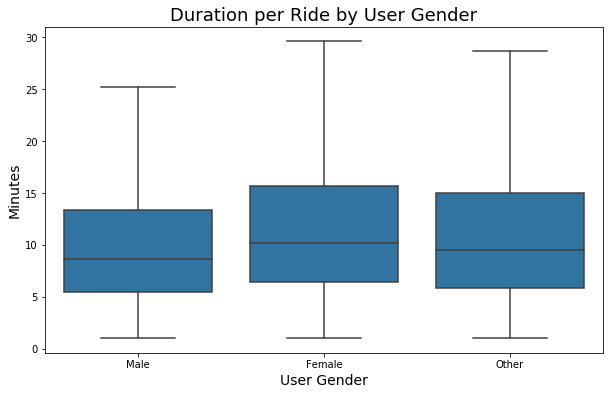

In [21]:
plt.figure(figsize=(10,6))
sb.boxplot(data=df_clean, x='member_gender', y='duration_min', color=base_color, showfliers=False)
plt.title('Duration per Ride by User Gender', fontsize=18)
plt.xlabel('User Gender', fontsize=14)
plt.ylabel('Minutes', fontsize=14);

## Age

- ’20-29’, ’30-39’ and ’40-49’ are the top3 user groups, with the ’30-39’ group being the largest. These three groups account for almost 89% of the rides
- While the ’30-39’ group is the largest during the week, the ’20-29’ group uses the service more than other groups on weekends 
- While the ’30-39’ group is the largest during the day (6 a.m. to 7 p.m.), the ’20-29’ group uses the service more than other groups from 8 p.m. to 2 a.m. 
- Compared to other groups, duration per ride for the ’18-19’ group is more sparsely distributed 

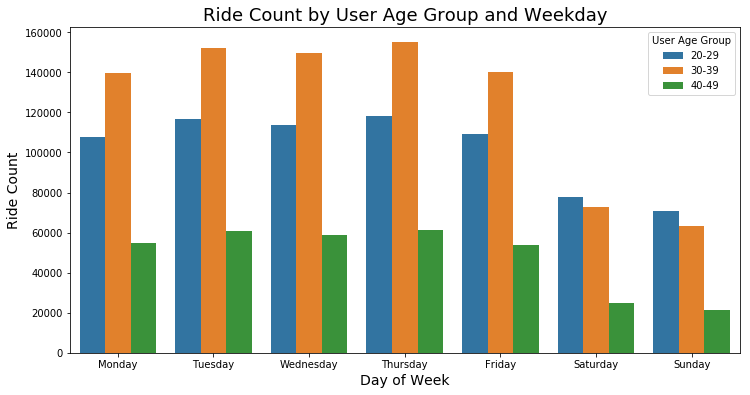

In [22]:
selected_age_group = ['20-29', '30-39', '40-49']
df_selected_age_group = df_clean[df_clean['member_age_group'].isin(selected_age_group)].reset_index()
weekday_index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
ax = sb.countplot(data=df_selected_age_group, x='start_time_weekday', hue='member_age_group', order=weekday_index, hue_order=selected_age_group)
ax.legend(title='User Age Group')
plt.title('Ride Count by User Age Group and Weekday', fontsize=18)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Ride Count', fontsize=14);

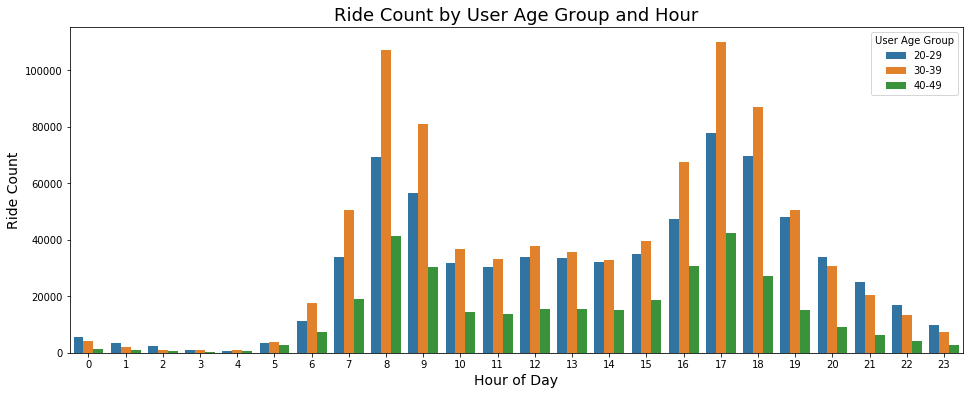

In [23]:
plt.figure(figsize=(16, 6))
ax = sb.countplot(data=df_selected_age_group, x='start_time_hour', hue='member_age_group', hue_order=selected_age_group)
ax.legend(title='User Age Group')
plt.title('Ride Count by User Age Group and Hour', fontsize=18)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Ride Count', fontsize=14);

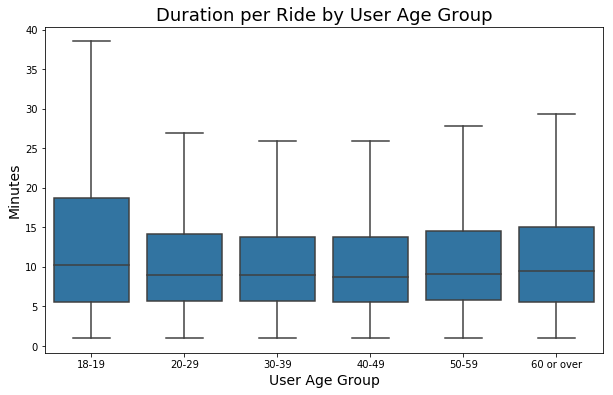

In [24]:
age_group = ['18-19', '20-29', '30-39', '40-49', '50-59', '60 or over']
plt.figure(figsize=(10,6))
sb.boxplot(data=df_clean, x='member_age_group', y='duration_min', color=base_color, order=age_group, showfliers=False)
plt.title('Duration per Ride by User Age Group', fontsize=18)
plt.xlabel('User Age Group', fontsize=14)
plt.ylabel('Minutes', fontsize=14);

## User Type

- The majority of the rides in the data is by the subscriber group, and the frequency is much higher than the customer group 
- The customer group is younger than the subscriber group. Specifically, the proportion of the ’20-29’ age group is slightly higher for the customer group 
- The proportion of female users in the customer group is slightly higher than the subscriber group
- The subscriber group uses the service more during the week while the customer group more on Saturdays 
- Both overall duration per ride and overall distance per ride for the customer group are longer than that of the subscriber group
    - A further investigation shows that while the overall duration per ride for the customer group is longer than the subscriber, it is only true for Friday and Sunday
    - Similar pattern also found in distance: while the overall distance per ride for the customer group is longer than the subscriber group, it is only true for Friday and Sunday

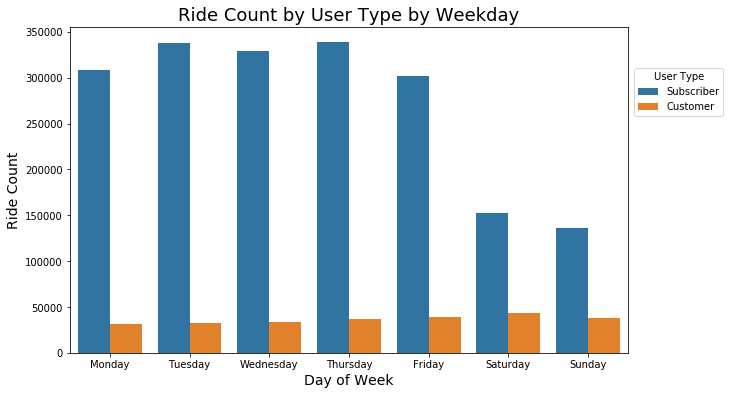

In [25]:
user_type = ['Subscriber', 'Customer']
plt.figure(figsize=(10, 6))
ax = sb.countplot(data=df_clean, x='start_time_weekday', hue='user_type', order=weekday_index, hue_order=user_type)
ax.legend(loc='right', bbox_to_anchor=(1.18, 0.8), title='User Type')
plt.title('Ride Count by User Type by Weekday', fontsize=18)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Ride Count', fontsize=14);

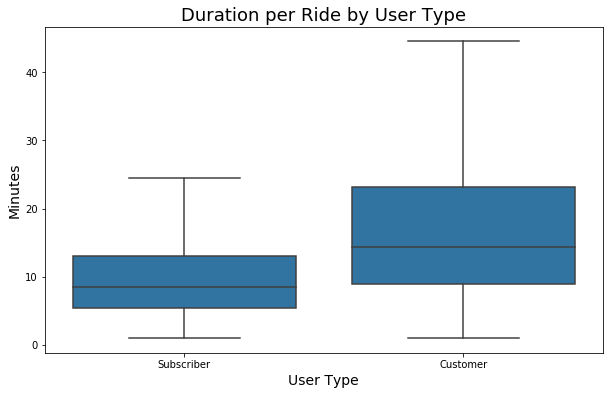

In [26]:
plt.figure(figsize=(10,6))
sb.boxplot(data=df_clean, x='user_type', y='duration_min', color=base_color, showfliers=False)
plt.title('Duration per Ride by User Type', fontsize=18)
plt.xlabel('User Type', fontsize=14)
plt.ylabel('Minutes', fontsize=14);

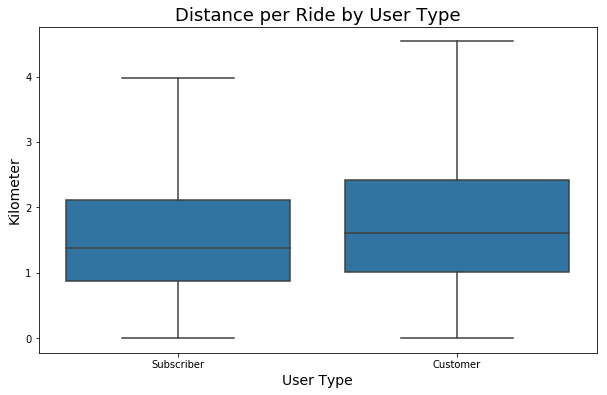

In [27]:
plt.figure(figsize=(10,6))
sb.boxplot(data=df_clean, x='user_type', y='distance', color=base_color, showfliers=False)
plt.title('Distance per Ride by User Type', fontsize=18)
plt.xlabel('User Type', fontsize=14)
plt.ylabel('Kilometer', fontsize=14);

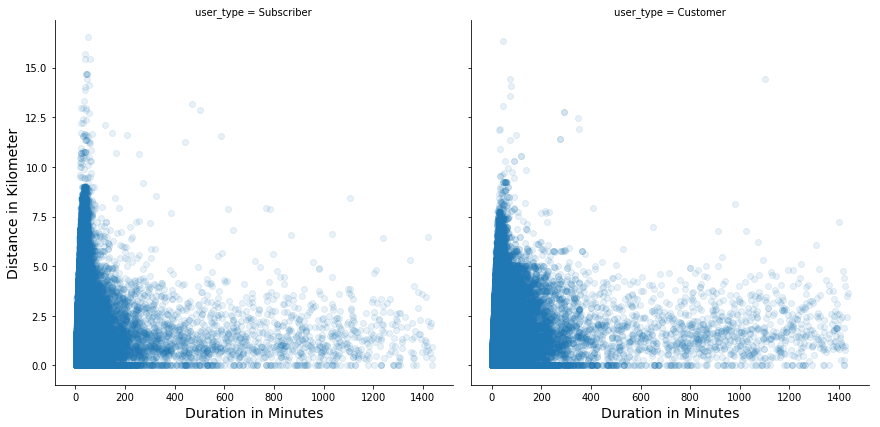

In [28]:
g = sb.FacetGrid(data=df_clean, col='user_type', col_wrap=3, size=6)
g.map(plt.scatter, 'duration_min', 'distance', alpha=0.1)
g.set_xlabels('Duration in Minutes', fontsize=14)
g.set_ylabels('Distance in Kilometer', fontsize=14);

In [29]:
warnings.filterwarnings("ignore")

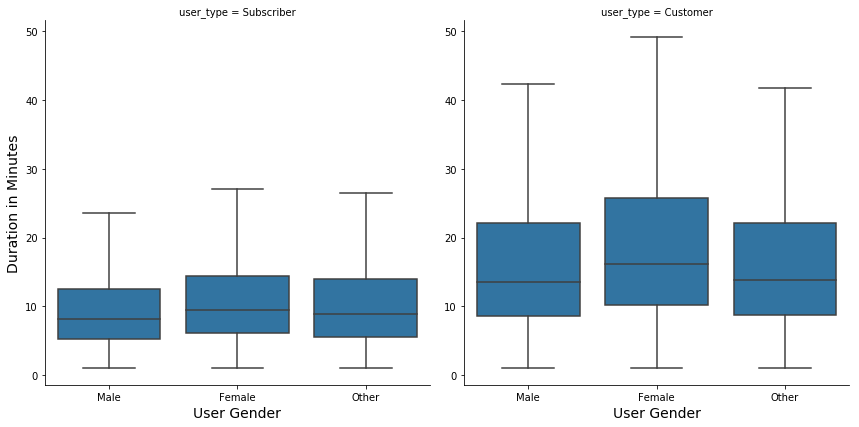

In [30]:
g = sb.FacetGrid(data=df_clean, col='user_type', size=6)
g.map(sb.boxplot, 'member_gender', 'duration_min', showfliers=False)
g.set_xlabels('User Gender', fontsize=14)
g.set_ylabels('Duration in Minutes', fontsize=14)
warnings.filterwarnings("ignore");

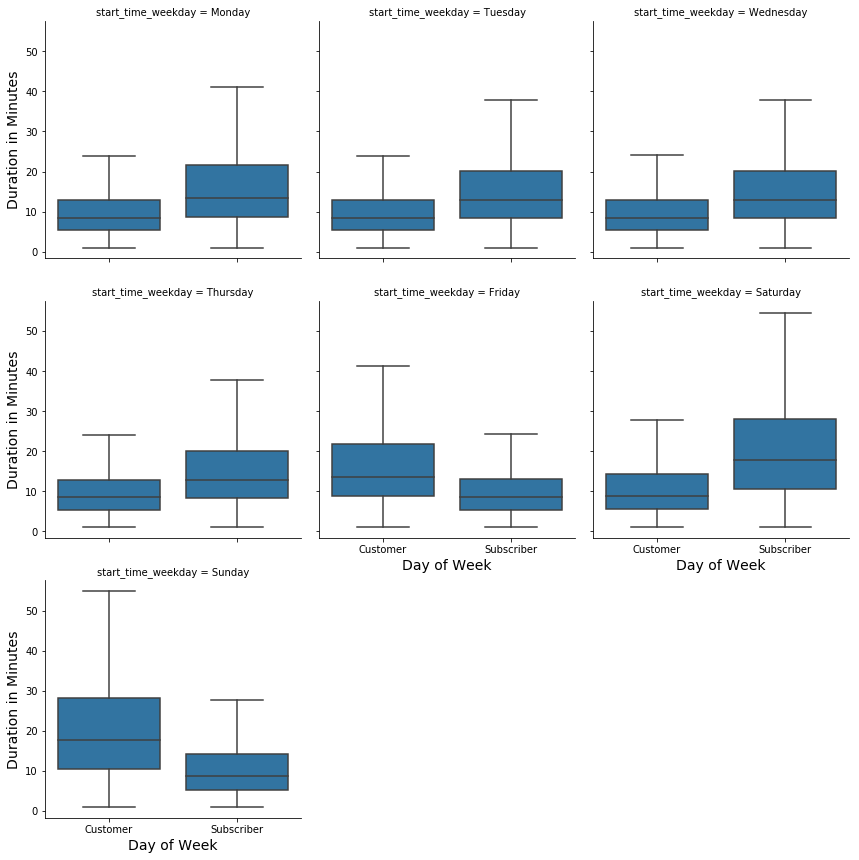

In [31]:
g = sb.FacetGrid(data=df_clean, col='start_time_weekday', col_order=weekday_index, col_wrap=3, size=4)
g.map(sb.boxplot, 'user_type', 'duration_min', showfliers=False)
g.set_xlabels('Day of Week', fontsize=14)
g.set_ylabels('Duration in Minutes', fontsize=14);

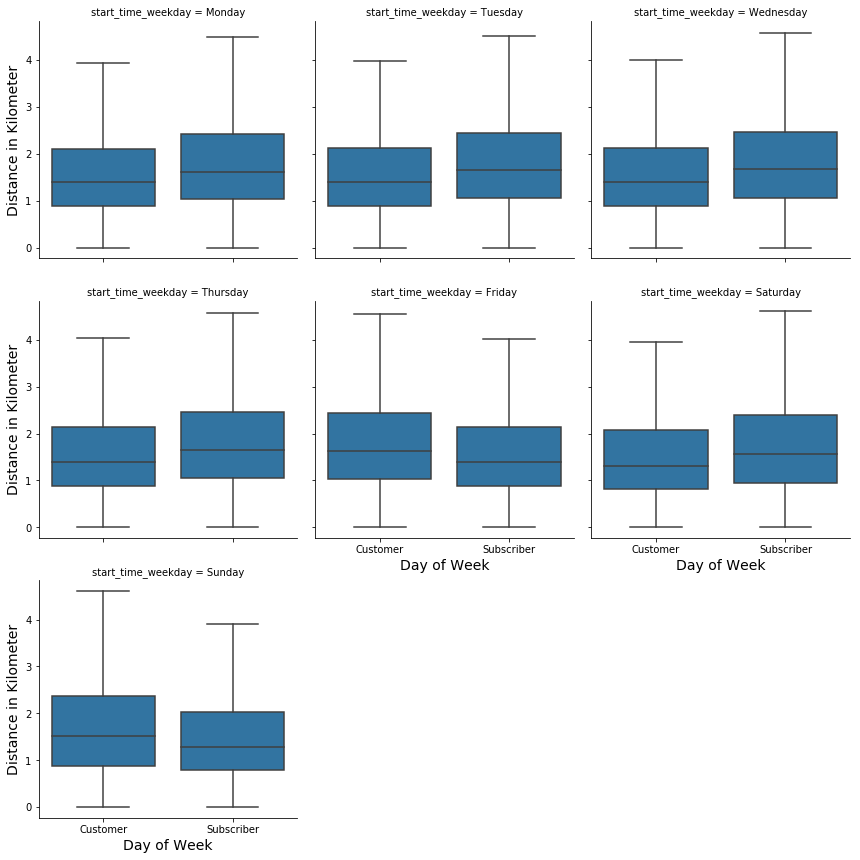

In [32]:
g = sb.FacetGrid(data=df_clean, col='start_time_weekday', col_order=weekday_index, col_wrap=3, size=4)
g.map(sb.boxplot, 'user_type', 'distance', showfliers=False)
g.set_xlabels('Day of Week', fontsize=14)
g.set_ylabels('Distance in Kilometer', fontsize=14);